In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("19-fraud_detection.csv")

In [3]:
df.head()

,transaction_amount,transaction_risk_score,is_fraud
0,1.879910,-1.485035,0
1,0.377083,-2.238585,0
2,1.354312,-2.664638,0
3,-0.509843,-1.502950,0
4,0.863561,-1.906364,0


In [4]:
df["is_fraud"].value_counts()

is_fraud
0    9846
1     154
Name: count, dtype: int64

Gördüğümüz üzere bu sınıfların sayıları arasında ciddi bir orantısızlık var.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   transaction_amount      10000 non-null  float64
 1   transaction_risk_score  10000 non-null  float64
 2   is_fraud                10000 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 234.5 KB


In [6]:
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

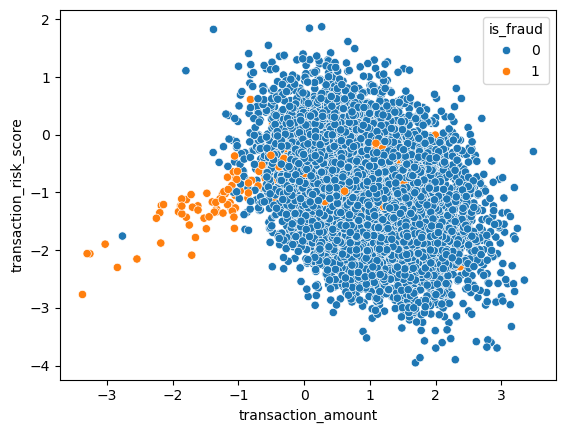

In [7]:
sns.scatterplot(x=X["transaction_amount"],y=X["transaction_risk_score"],hue=y)
plt.show()

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
model = LogisticRegression()

In [12]:
penalty=['l1', 'l2', 'elasticnet']
c_values=[100,10,1.0,0.1,0.01]
solver=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
class_weight=[{0:w,1:y} for w in [1,10,50,100] for y in [1,10,50,100]]
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [13]:
params=dict(penalty=penalty,C=c_values,solver=solver,class_weight=class_weight)

### class_weight Nedir?

class_weight, sınıflar arasında dengesizlik (imbalance) varsa bunu telafi etmek için kullanılır. Özellikle lojistik regresyon, SVM ve bazı sınıflandırma algoritmalarında kullanılır.

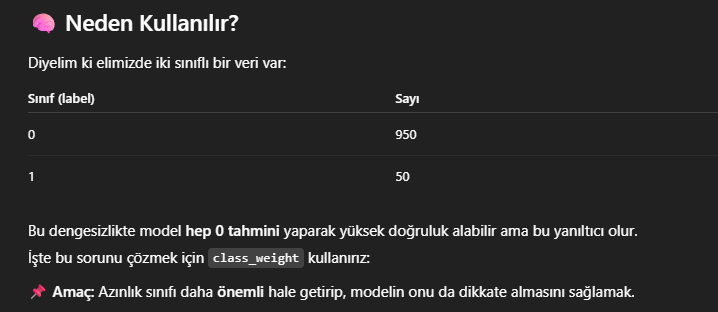

- class_weight, modelin kayıp fonksiyonu (loss function) içinde, her sınıfa özel bir ağırlık (weight) verir.

- Az görülen sınıfa yüksek ağırlık verir.

- Sık görülen sınıfa daha düşük ağırlık verir.

Model artık:

“Azınlık sınıfında hata yaparsam cezam büyük”
diye düşünerek ona daha fazla önem verir.

`Yani kısaca dengesiz veri setlerinde modelin azınlık sınıfı tanımasını sağlar`

In [14]:
from sklearn.model_selection import StratifiedKFold

In [15]:
cv = StratifiedKFold()

In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
grid=GridSearchCV(estimator=model,param_grid=params,scoring='accuracy',cv=cv)

In [18]:
import warnings
warnings.filterwarnings('ignore')
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(),
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01],
                         'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 10},
                                          {0: 1, 1: 50}, {0: 1, 1: 100},
                                          {0: 10, 1: 1}, {0: 10, 1: 10},
                                          {0: 10, 1: 50}, {0: 10, 1: 100},
                                          {0: 50, 1: 1}, {0: 50, 1: 10},
                                          {0: 50, 1: 50}, {0: 50, 1: 100},
                                          {0: 100, 1: 1}, {0: 100, 1: 10},
                                          {0: 100, 1: 50}, {0: 100, 1: 100}],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='accuracy')

In [19]:
y_pred = grid.predict(X_test)

In [20]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [21]:
score=accuracy_score(y_pred,y_test)
print("score: ", score)
print(classification_report(y_pred,y_test))
print("confusion matrix: \n " , confusion_matrix(y_pred,y_test))

score:  0.9893333333333333
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2977
           1       0.41      0.87      0.56        23

    accuracy                           0.99      3000
   macro avg       0.70      0.93      0.78      3000
weighted avg       0.99      0.99      0.99      3000

confusion matrix: 
  [[2948   29]
 [   3   20]]


In [22]:
grid.best_params_

{'C': 0.01,
 'class_weight': {0: 10, 1: 50},
 'penalty': 'l2',
 'solver': 'newton-cg'}

# ROC , AUC

The ROC Curve is a graphical representation of a classification model’s performance across different threshold values. It plots the True Positive Rate (Recall) on the Y-axis against the False Positive Rate (1 - Specificity) on the X-axis. • A model that perfectly distinguishes between classes has a curve that reaches the top-left corner. • The closer the curve is to the top-left, the better the model. • The area under the ROC curve (AUC) quantifies this performance: • AUC = 1 → perfect classifier • AUC = 0.5 → random guessing

ROC is especially useful for imbalanced datasets, as it evaluates the model independent of class distribution or threshold.

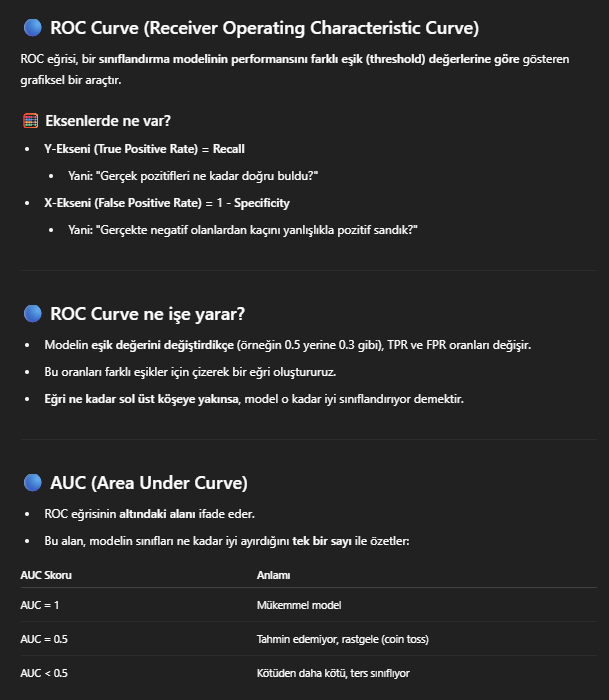

Ne zaman kullanılır?
- Dengesiz (imbalanced) veri setlerinde özellikle çok faydalıdır.

- Çünkü ROC eğrisi, eşik değerinden veya sınıf dağılımından bağımsızdır.

    - Accuracy bu gibi durumlarda yanıltıcı olabilir ama ROC/AUC olmaz.



## Özetle:

### ROC/AUC:

- Modelin sınıfları ne kadar iyi ayırdığını gösterir.

- Eşik bağımsızdır.

- Dengesiz sınıflarda güçlü bir ölçüttür.

- AUC = 1'e ne kadar yakınsa, model o kadar iyi.



In [25]:
model_prob = grid.predict_proba(X_test)

In [26]:
model_prob

array([[0.99541523, 0.00458477],
       [0.85804185, 0.14195815],
       [0.95194979, 0.04805021],
       ...,
       [0.96100575, 0.03899425],
       [0.98625237, 0.01374763],
       [0.76576844, 0.23423156]])

In [27]:
##  probabilities for the positive class
model_prob=model_prob[:,1]

In [28]:
from sklearn.metrics import roc_curve, roc_auc_score

In [29]:
model_auc = roc_auc_score(y_test, model_prob)

In [30]:
model_auc

0.779196260001798

In [31]:
# model false positive rate
# model true positive rate
model_fpr, model_tpr, thresholds = roc_curve(y_test, model_prob)

In [32]:
thresholds

array([           inf, 9.62289183e-01, 5.56689478e-01, 5.20333038e-01,
       4.73633988e-01, 2.92065100e-01, 2.91358923e-01, 2.85291305e-01,
       2.84972373e-01, 2.58547298e-01, 2.58441642e-01, 2.54043948e-01,
       2.51757986e-01, 2.46808524e-01, 2.45332437e-01, 2.15177993e-01,
       2.14157022e-01, 1.75667426e-01, 1.74713033e-01, 1.69828268e-01,
       1.69512914e-01, 1.36162753e-01, 1.36142427e-01, 8.06972027e-02,
       8.05542040e-02, 7.24229225e-02, 7.23816240e-02, 6.02072382e-02,
       6.01464069e-02, 5.85330107e-02, 5.85144163e-02, 4.61822739e-02,
       4.61559643e-02, 4.58761410e-02, 4.57879858e-02, 3.16646536e-02,
       3.16055455e-02, 2.59337092e-02, 2.59219894e-02, 2.47081298e-02,
       2.46611039e-02, 2.41151827e-02, 2.41081983e-02, 2.29808347e-02,
       2.29505212e-02, 1.89909319e-02, 1.89763495e-02, 1.54020903e-02,
       1.53422913e-02, 1.49701118e-02, 1.49681408e-02, 1.16113043e-02,
       1.15848558e-02, 1.09227043e-02, 1.08996568e-02, 1.00786797e-02,
      

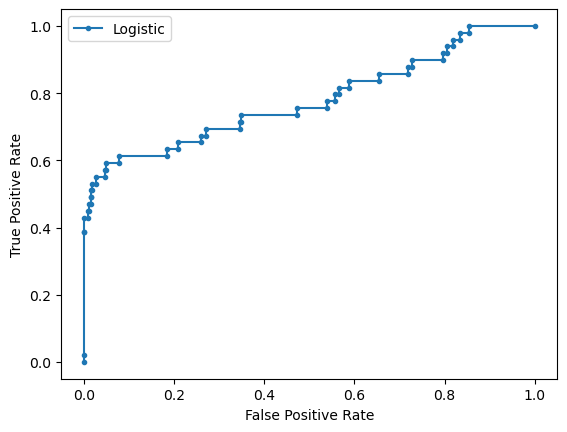

In [33]:
plt.plot(model_fpr, model_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

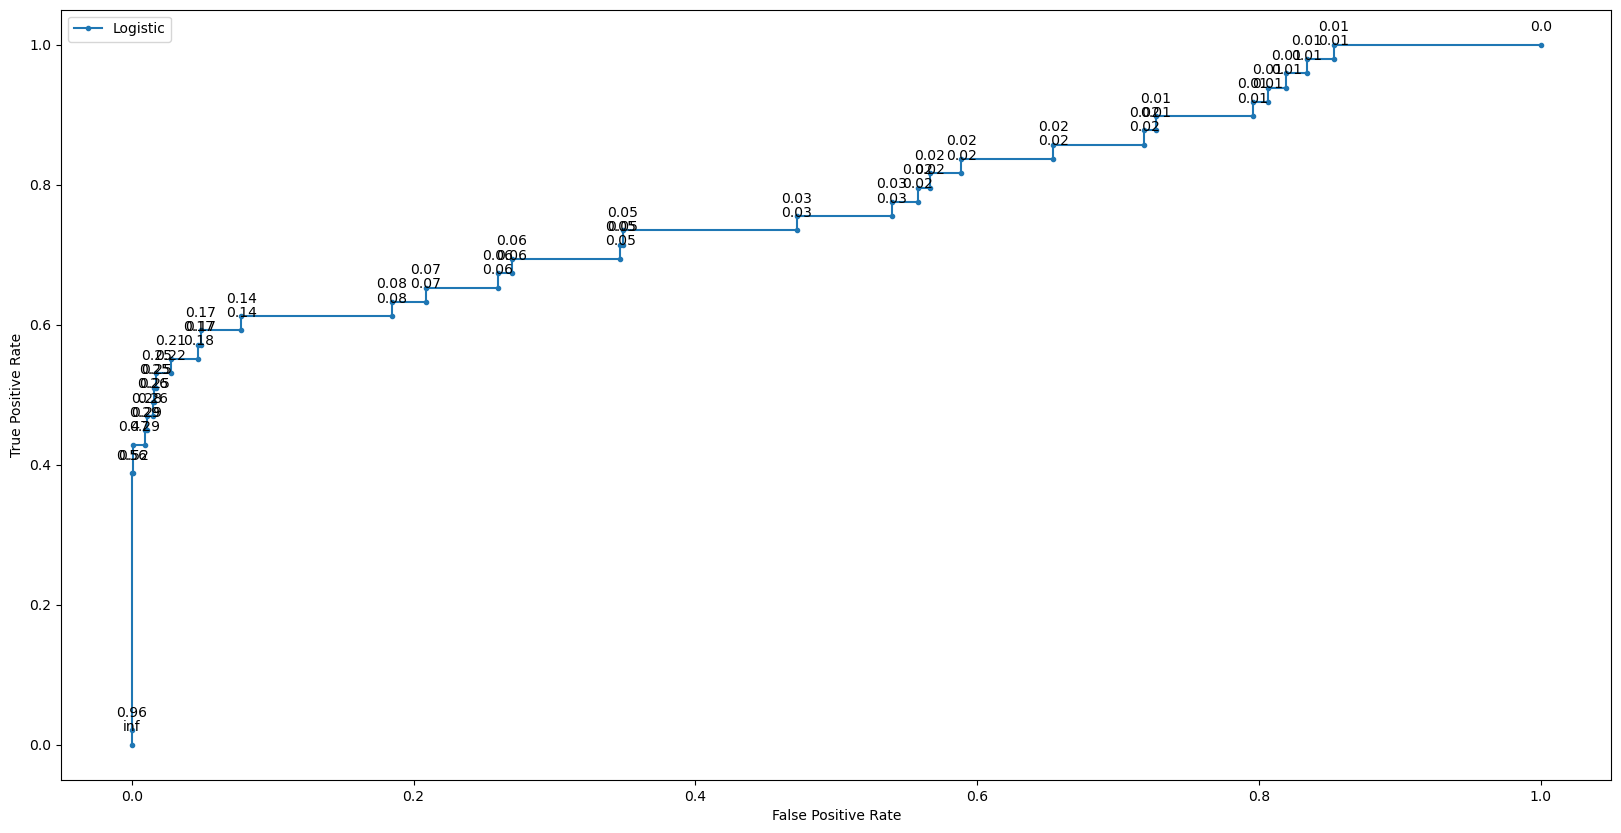

In [35]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(20, 10))

# Plot ROC curve
ax.plot(model_fpr, model_tpr, marker='.', label='Logistic')

# Annotate each point with the threshold
for fpr, tpr, thresh in zip(model_fpr, model_tpr, thresholds):
    ax.annotate(f'{np.round(thresh, 2)}', (fpr, tpr), textcoords="offset points", xytext=(0,10), ha='center')

# Labels and legend
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

# Show the plot
plt.show()